# Modelling and Evaluation

## Objectives

* Write here your notebook objective, for example, "Fetch data from Kaggle and save as raw data", or "engineer features for modelling"

## Inputs

* Write here which data or information you need to run the notebook 

## Outputs

* Write here which files, code or artefacts you generate by the end of the notebook 

## Additional Comments

* In case you have any additional comments that don't fit in the previous bullets, please state them here. 



---

## Import packages

In [51]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

## Set working directory

In [52]:
cwd = os.getcwd()
cwd

'/workspaces/mildew-detector'

In [ ]:
os.chdir('/workspaces/mildew-detector')
print("You set a new current directory")

In [ ]:
work_dir = os.getcwd()
work_dir

---

## Set input directories

* Set train, validation and test paths

In [53]:
my_data_dir = 'inputs/cherry_leaves_dataset/cherry-leaves'
train_path = my_data_dir + '/train'
val_path = my_data_dir + '/validation'
test_path = my_data_dir + '/test'

## Set output directory

In [54]:
version = 'v1'
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(work_dir) and version in os.listdir(work_dir + '/outputs'):
  print('Old version is already available create a new version.')
  pass
else:
  os.makedirs(name=file_path)

Old version is already available create a new version.


## Set labels

In [55]:
labels = os.listdir(train_path)

print(
    f"Image labels are: {labels}"
    )

Image labels are: ['healthy', 'powdery_mildew']


## Set image shape

In [56]:
import joblib
version = 'v1'
image_shape = joblib.load(filename=f"outputs/{version}/image_shape.pkl")
image_shape

(256, 256, 3)

---

## Image count in train, validation and test data

* train - healthy: 1472 images
* train - powdery_mildew: 1472 images
* validation - healthy: 210 images
* validation - powdery_mildew: 210 images
* test - healthy: 422 images
* test - powdery_mildew: 422 images




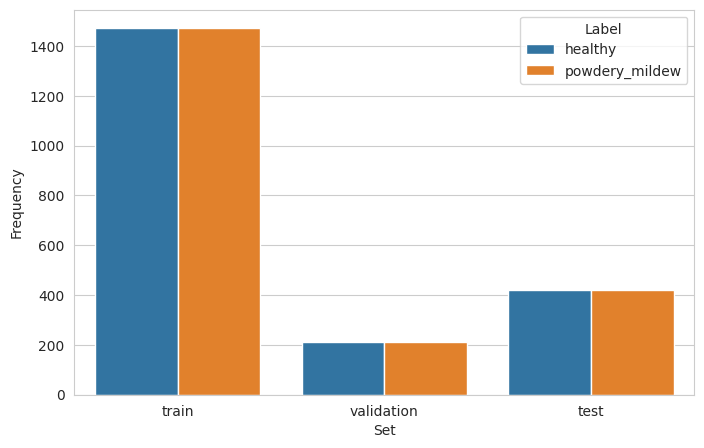

In [57]:
df_freq = pd.DataFrame([]) 
for folder in ['train', 'validation', 'test']:
  for label in labels:
    df_freq = df_freq.append(
        pd.Series(data={'Set': folder,
                        'Label': label,
                        'Frequency':int(len(os.listdir(my_data_dir+'/'+ folder + '/' + label)))}
                  ),
                  ignore_index=True
        )
    
    print(f"* {folder} - {label}: {len(os.listdir(my_data_dir+'/'+ folder + '/' + label))} images")

print("\n")
sns.set_style("whitegrid")
plt.figure(figsize=(8,5))
sns.barplot(data=df_freq, x='Set', y='Frequency', hue='Label')
plt.savefig(f'{file_path}/labels_distribution.png', bbox_inches='tight', dpi=150)
plt.show()

---

## Image data augmentation

### Import ImageDataGenerator

In [58]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### Initialize ImageDataGenerator

In [59]:
augmented_image_data = ImageDataGenerator(rotation_range=20,
                                   width_shift_range=0.10, 
                                   height_shift_range=0.10,
                                   shear_range=0.1,
                                   zoom_range=0.1,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   fill_mode='nearest',
                                   rescale=1./255
                              )

### Set batch size

In [ ]:
batch_size = 16

### Augment and plot training image dataset

In [60]:
train_set = augmented_image_data.flow_from_directory(train_path,
                                              target_size=image_shape[:2],
                                              color_mode='rgb',
                                              batch_size=batch_size,
                                              class_mode='categorical',
                                              shuffle=True
                                              )

train_set.class_indices

Found 2944 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

(16, 256, 256, 3)


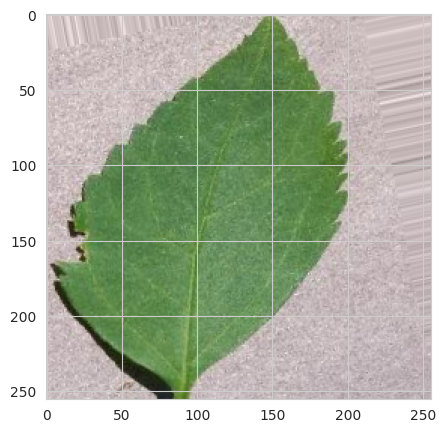

(16, 256, 256, 3)


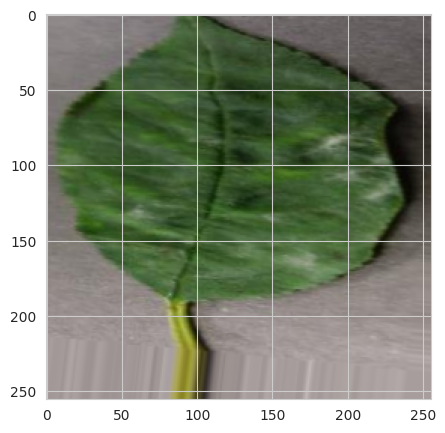

(16, 256, 256, 3)


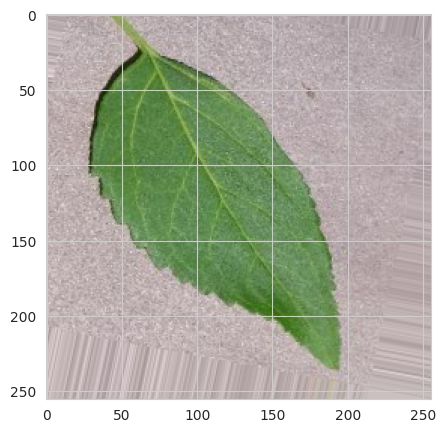

In [61]:
for _ in range(3):
    plt.figure(figsize=(5, 5))
    img, label = train_set.next()
    print(img.shape)  
    plt.imshow(img[0])
    plt.show()

### Augment and plot validation image dataset

In [ ]:
validation_set = ImageDataGenerator(rescale=1./255).flow_from_directory(val_path,
                                                          target_size=image_shape[:2],
                                                          color_mode='rgb',
                                                          batch_size=batch_size,
                                                          class_mode='categorical',
                                                          shuffle=False
                                                          )

validation_set.class_indices

(16, 256, 256, 3)


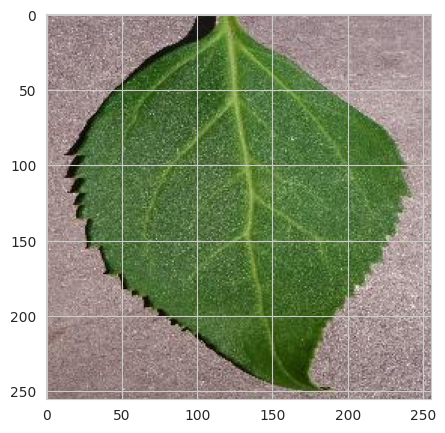

(16, 256, 256, 3)


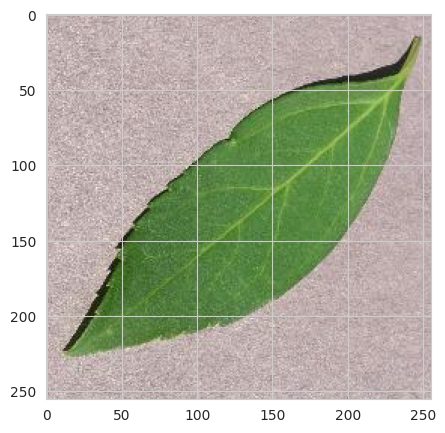

(16, 256, 256, 3)


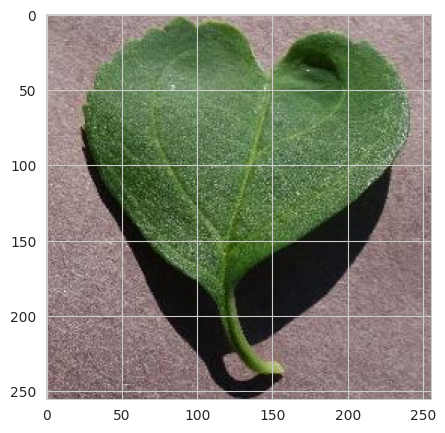

In [62]:
for _ in range(3):
    plt.figure(figsize=(5, 5))
    img, label = validation_set.next()
    print(img.shape)  
    plt.imshow(img[0])
    plt.show()

### Augment and plot test image dataset

In [63]:
test_set = ImageDataGenerator(rescale=1./255).flow_from_directory(test_path,
                                                    target_size=image_shape[:2],
                                                    color_mode='rgb',
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=False
                                                    )

test_set.class_indices

Found 844 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

(16, 256, 256, 3)


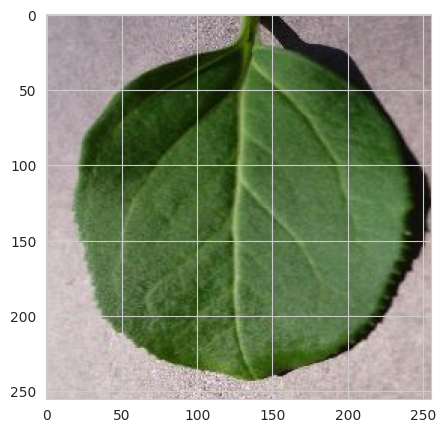

(16, 256, 256, 3)


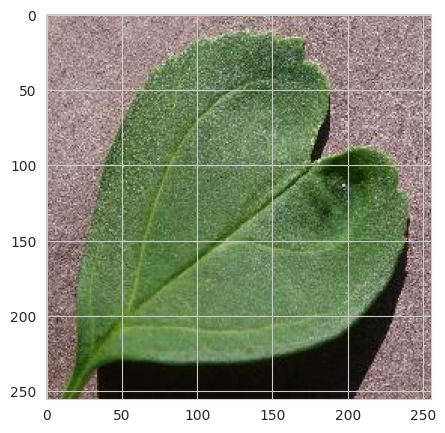

(16, 256, 256, 3)


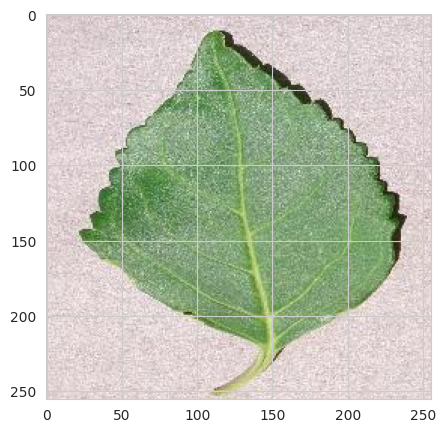

In [64]:
for _ in range(3):
    plt.figure(figsize=(5, 5))
    img, label = test_set.next()
    print(img.shape)  
    plt.imshow(img[0])
    plt.show()

### Save class_indices

In [65]:
joblib.dump(value=train_set.class_indices ,
            filename=f"{file_path}/class_indices.pkl")

['outputs/v1/class_indices.pkl']

---

## Model creation

### Import model packages

In [66]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D

### Model

In [67]:
def create_tf_model():
    model = Sequential()

    model.add(Conv2D(filters=32, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=32, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(64, activation = 'relu'))

    model.add(Dropout(0.2))
    model.add(Dense(2, activation = 'softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='adagrad',
                  metrics=['accuracy'])
    
    return model

### Model summary

In [68]:
create_tf_model().summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 125, 125, 32)      9248      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 60, 60, 64)        18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 57600)            

### Early stopping

In [69]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_accuracy',patience=2)

### Fit model for training

In [70]:
model = create_tf_model()
model.fit(train_set,
          epochs=11,
          steps_per_epoch = len(train_set.classes) // batch_size,
          validation_data=validation_set,
          callbacks=[early_stop],
          verbose=1
          )

Epoch 1/11
184/184 [==============================] - 285s 2s/step - loss: 0.5903 - accuracy: 0.6980 - val_loss: 0.3886 - val_accuracy: 0.8548
Epoch 2/11
184/184 [==============================] - 290s 2s/step - loss: 0.3548 - accuracy: 0.8424 - val_loss: 0.2632 - val_accuracy: 0.8810
Epoch 3/11
184/184 [==============================] - 287s 2s/step - loss: 0.3171 - accuracy: 0.8607 - val_loss: 0.2350 - val_accuracy: 0.9071
Epoch 4/11
184/184 [==============================] - 274s 1s/step - loss: 0.2659 - accuracy: 0.8842 - val_loss: 0.1954 - val_accuracy: 0.9286
Epoch 5/11
184/184 [==============================] - 281s 2s/step - loss: 0.2366 - accuracy: 0.9046 - val_loss: 0.1691 - val_accuracy: 0.9333
Epoch 6/11
184/184 [==============================] - 283s 2s/step - loss: 0.2114 - accuracy: 0.9158 - val_loss: 0.1701 - val_accuracy: 0.9071
Epoch 7/11
184/184 [==============================] - 282s 2s/step - loss: 0.1860 - accuracy: 0.9317 - val_loss: 0.1503 - val_accuracy: 0.9214

### Save model

In [71]:
model.save('outputs/v1/mildew_detector_model.h5')

---

## Model performance

### Model learning curve

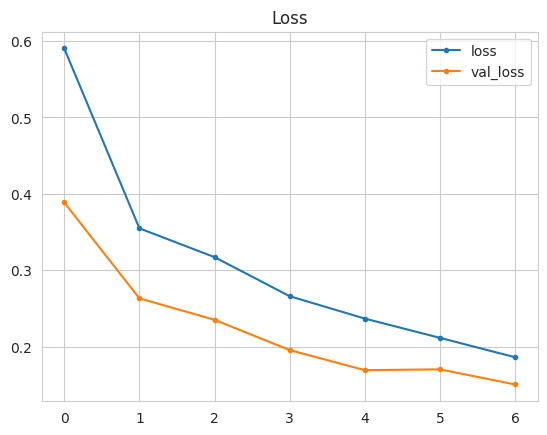

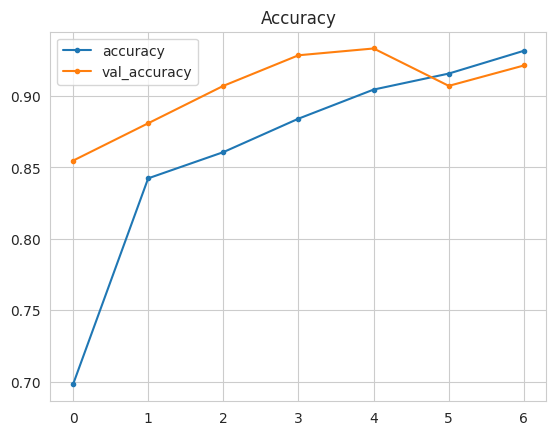

In [72]:
losses = pd.DataFrame(model.history.history)

sns.set_style("whitegrid")
losses[['loss','val_loss']].plot(style='.-')
plt.title("Loss")
plt.savefig(f'{file_path}/model_training_losses.png', bbox_inches='tight', dpi=150)
plt.show()

print("\n")
losses[['accuracy','val_accuracy']].plot(style='.-')
plt.title("Accuracy")
plt.savefig(f'{file_path}/model_training_acc.png', bbox_inches='tight', dpi=150)
plt.show()

---

## Model evaluation

* Load saved model

In [73]:
from keras.models import load_model
model = load_model('outputs/v1/mildew_detector_model.h5')

* Evaluate model on test set

In [74]:
evaluation = model.evaluate(test_set)

53/53 [==============================] - 19s 347ms/step - loss: 0.1632 - accuracy: 0.9336


* Set accuracy variables

In [75]:
validation_set.reset()

x_true, y_true = next(test_set)
preds = np.argmax(model.predict(test_set), axis=1)
y_pred = np.rint(preds)
y_true = test_set.labels

### Confusion matrix

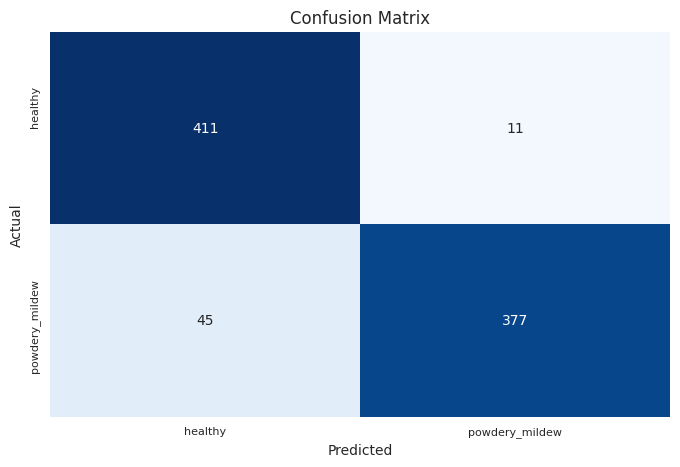

In [76]:
from sklearn.metrics import classification_report, confusion_matrix
cm = confusion_matrix(y_true,y_pred)

classes=list(test_set.class_indices.keys()) 
length=len(classes)
plt.figure(figsize=(8, 5))
sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
plt.xticks(np.arange(length)+.5, classes, rotation= 0, fontsize=8)
plt.yticks(np.arange(length)+.3, classes, rotation=90, fontsize=8)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.savefig(f'{file_path}/confusion_matrix.png',
            bbox_inches='tight', dpi=150)
plt.show()

### Classification report

In [77]:
print(classification_report(test_set.classes, y_pred, 
      target_names=labels))

                precision    recall  f1-score   support

       healthy       0.90      0.97      0.94       422
powdery_mildew       0.97      0.89      0.93       422

      accuracy                           0.93       844
     macro avg       0.94      0.93      0.93       844
  weighted avg       0.94      0.93      0.93       844



* Save evaluation pickle

In [78]:
joblib.dump(value=evaluation ,
            filename=f"outputs/v1/evaluation.pkl")

['outputs/v1/evaluation.pkl']

---

## Predict on new data

* Load a random image as PIL

Image shape: (256, 256), Image mode: RGB


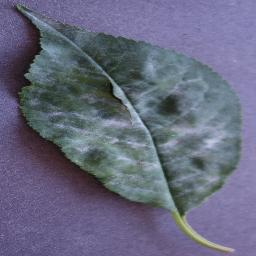

In [82]:
from tensorflow.keras.preprocessing import image

pointer = 33
label = labels[1]  # select 0 for 'health' or 1 for 'powdery_mildew'

pil_image = image.load_img(test_path + '/' + label + '/' + os.listdir(test_path+'/' + label)[pointer],
                           target_size=image_shape, color_mode='rgb')
print(f'Image shape: {pil_image.size}, Image mode: {pil_image.mode}')
pil_image

* Convert image to array and prepare for prediction

In [83]:
my_image = image.img_to_array(pil_image)
my_image = np.expand_dims(my_image, axis=0)/255
print(my_image.shape)

(1, 256, 256, 3)


* Predict class probabilities

In [84]:
pred_proba = model.predict(my_image)[0, 0]

target_map = {v: k for k, v in train_set.class_indices.items()}
pred_class = target_map[pred_proba < 0.5]

if pred_class == target_map[1]:
    pred_proba = 1 - pred_proba

print(pred_proba)
print(pred_class)

0.9731832463294268
powdery_mildew


---

## Push files to Repo

* .gitignore

In [85]:
!cat .gitignore

core.Microsoft*
core.mongo*
core.python*
env.py
__pycache__/
*.py[cod]
node_modules/
.github/
cloudinary_python.txt
kaggle.json

* git status

In [86]:
!git status

On branch main
Your branch is up to date with 'origin/main'.

Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git restore <file>..." to discard changes in working directory)
	modified:   jupyter_notebooks/Modelling_Evaluation.ipynb
	modified:   outputs/v1/confusion_matrix.png
	modified:   outputs/v1/evaluation.pkl
	modified:   outputs/v1/mildew_detector_model.h5
	modified:   outputs/v1/model_training_acc.png
	modified:   outputs/v1/model_training_losses.png

no changes added to commit (use "git add" and/or "git commit -a")


* git add

In [ ]:
!git add .

* git commit

In [ ]:
!git commit -am "Evaluate model"

* git push

In [ ]:
!git push

In [ ]:
!git status